In [1]:
import pandas as pd

# prerequisites
import torch
th = torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.family'] = 'serif'
import numpy as np


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

to_tensor = lambda x: torch.tensor(x).to(torch.float32)

C:\Users\berni\anaconda3\envs\hku_202324S2\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\berni\anaconda3\envs\hku_202324S2\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\berni\anaconda3\envs\hku_202324S2\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class CustomDataset(Dataset):
    def __init__(self, X, y):
        # Generate random data for X with shape (N, 20)
        self.X = X
        # Generate random data for y with shape (N, 18, 10)
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



# TODO: DATASET IMPORT

In [3]:
X = th.randint(2, size=(500, 20)).to(th.float)
y = th.rand(500,18,10)
# Instantiate the dataset
dataset = CustomDataset(X,y)

In [4]:
# Define the split sizes
eval_percent = 0.10
num_eval = int(len(dataset) * eval_percent)
num_train = len(dataset) - num_eval

# Randomly split the dataset into training and evaluation datasets
train_dataset, test_dataset = random_split(dataset, [num_train, num_eval])

print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Set batch size
batch_size = 50

# Create DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for the evaluation dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training dataset size: 450
Test dataset size: 50


In [5]:
import os
import torch

def save_models(models, folder_path):
    # Create the directory if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Save each model
    for model in models:
        model_name = type(model).__name__  # Get the class name of the model
        file_path = os.path.join(folder_path, f"{model_name}.pt")
        torch.save(model.state_dict(), file_path)

    print("Models saved successfully.")

# Example usage:
# save_models([model1, model2], "/path/to/folder")

def load_models(model_objects, folder_path):
    # Load the state dicts for each model
    for model in model_objects:
        model_name = type(model).__name__  # Get the class name of the model
        file_path = os.path.join(folder_path, f"{model_name}.pt")
        model.load_state_dict(torch.load(file_path))

    print("Models loaded successfully.")

# Example usage:
# load_models([model1, model2], "/path/to/folder")



In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomConvNet(nn.Module):
    def __init__(self, num_1d_layers=3, num_2d_layers=2):# num_channels=180):
        super(CustomConvNet, self).__init__()
        
        # Define initial parameters for the 1D conv layers
        initial_channels = 16  # Initial number of channels
        self.shape_1d = 20
        self.shape_2d = (18, 10)
        
        # 1D Convolutional Layers
        self.conv1d_layers = nn.ModuleList()
        in_channels = 1
        for i in range(num_1d_layers - 1):
            out_channels = initial_channels * (2 ** i)
            self.conv1d_layers.append(nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1)  # Regularization
            ))
            in_channels = out_channels
        
        # Last 1D convolution to adjust the channel size exactly to num_channels
        self.conv1d_layers.append(nn.Conv1d(in_channels, self.shape_2d[0] * self.shape_2d[1], 
                                            kernel_size=3, stride=1, padding=1))
        #print(num_channels)
        
        # 2D Convolutional Layers
        self.conv2d_layers = nn.ModuleList()
        in_channels = self.shape_1d
        for i in range(num_2d_layers):
            out_channels = 32 if i < num_2d_layers - 1 else 1  # Final output channel set to 1
            self.conv2d_layers.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=1, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2)  # Regularization
            ))
            in_channels = out_channels

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension (N, 1, L) where L is the sequence length

        # Apply 1D convolutions
        for layer in self.conv1d_layers:
            x = layer(x)

        # Reshape to 2D (N, C, 18, 10)
        x = x.view(x.size(0), -1, 18, 10)  # -1 here will automatically adjust to num_channels
        
        # Apply 2D convolutions
        for layer in self.conv2d_layers:
            x = layer(x)

        return x.squeeze(1)


In [7]:

def train_model(model, optimizer, train_loader, losses, epochs=1000):
    model.train()
    losses_ = losses.setdefault('train',{})
    
    for epoch in range(epochs):
        loss, metric = 0., 0.
        for iter, (inputs, targets) in enumerate(train_loader):
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = train_loss_func(outputs, targets)
            loss.backward()
            optimizer.step()

            metric = test_eval_func(outputs.detach(), targets)

            loss += loss.detach()
            metric += metric.detach()
            
        loss /= (iter + 1)
        metric /= (iter + 1)
        
        losses_.setdefault('loss', []).append(loss.detach())
        losses_.setdefault('metric', []).append(metric.detach())
        losses_.setdefault('epoch', []).append(epoch)

        if (epoch+1) % 5 == 0:
            print(f'TRAIN | Epoch {epoch+1}, Loss: {loss.item():.4f}, Metric: {metric.item():.4f}')
            test(model, epoch, losses)

def test(model, epoch, losses):
    _ = model.eval()
    losses_ = losses.setdefault('test',{})
    
    with torch.no_grad():
        loss, metric = 0., 0.
        for iter, (inputs, targets) in enumerate(test_loader):
            outputs = model(inputs)
            loss = train_loss_func(outputs.detach(), targets.detach()).detach()
            metric = test_eval_func(outputs.detach(), targets.detach()).detach()
            
        loss /= (iter + 1)
        metric /= (iter + 1)
        losses_.setdefault('loss', []).append(loss)
        losses_.setdefault('metric', []).append(metric)
        losses_.setdefault('epoch', []).append(epoch)
            
    print(f'... TEST | Epoch {epoch+1}, Loss: {loss.item():.4f}, Metric: {metric.item():.4f}')


In [8]:
class MAPELoss(torch.nn.Module):
    def __init__(self):
        super(MAPELoss, self).__init__()

    def forward(self, y_true, y_pred):
        epsilon = 1e-8
        percentage_error = torch.abs((y_true - y_pred) / (torch.abs(y_true) + epsilon))
        mape = torch.mean(percentage_error) * 100.0
        return mape

train_loss_func = nn.MSELoss()
test_eval_func = MAPELoss()

In [9]:

# Create the model
model = CustomConvNet(num_1d_layers=3, num_2d_layers=2)

if False: # test the model
    #print(model)
    # Creating a dummy input tensor of shape (N, L), where L=20
    input_tensor = torch.randn(5, 20)  # 5 examples, each 1 x 20
    # Forward pass
    output = model(input_tensor)
    print("Output shape:", output.shape)


In [76]:
# Train model

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = {}
train_model(model, optimizer, train_loader, losses,  epochs=100)

TRAIN | Epoch 5, Loss: 0.0397, Metric: 410726944.0000
... TEST | Epoch 5, Loss: 0.1477, Metric: 1112320256.0000
TRAIN | Epoch 10, Loss: 0.0188, Metric: 11.0236
... TEST | Epoch 10, Loss: 0.0846, Metric: 49.3543
TRAIN | Epoch 15, Loss: 0.0187, Metric: 11.2369
... TEST | Epoch 15, Loss: 0.0842, Metric: 50.5873
TRAIN | Epoch 20, Loss: 0.0186, Metric: 11.1766
... TEST | Epoch 20, Loss: 0.0842, Metric: 50.4633
TRAIN | Epoch 25, Loss: 0.0185, Metric: 11.1703
... TEST | Epoch 25, Loss: 0.0841, Metric: 50.5310
TRAIN | Epoch 30, Loss: 0.0183, Metric: 11.1016
... TEST | Epoch 30, Loss: 0.0841, Metric: 50.4536
TRAIN | Epoch 35, Loss: 0.0185, Metric: 11.0965
... TEST | Epoch 35, Loss: 0.0841, Metric: 50.2991
TRAIN | Epoch 40, Loss: 0.0183, Metric: 11.0601
... TEST | Epoch 40, Loss: 0.0841, Metric: 50.3756
TRAIN | Epoch 45, Loss: 0.0185, Metric: 11.1294
... TEST | Epoch 45, Loss: 0.0841, Metric: 50.3412
TRAIN | Epoch 50, Loss: 0.0184, Metric: 11.0720
... TEST | Epoch 50, Loss: 0.0841, Metric: 50.22

KeyboardInterrupt: 

# save & load models

In [48]:
save_models([model], "model/")

Models saved successfully.


In [56]:
load_models([model], "model/")

Models loaded successfully.


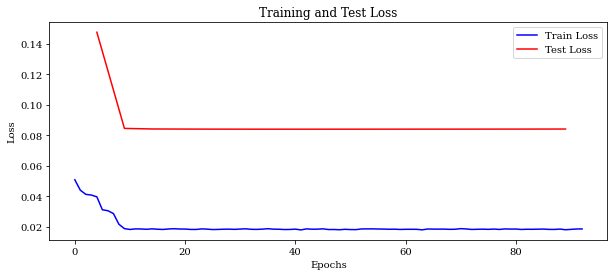

In [77]:
import matplotlib.pyplot as plt

# Plotting the loss
fig, ax = plt.subplots(figsize=(10,4))
key='loss'
ax.plot(losses['train']['epoch'], losses['train'][key], label='Train Loss', c='blue')
ax.plot(losses['test']['epoch'], losses['test'][key], label='Test Loss', c='red')

# Adding labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training and Test Loss')

# Adding legend
ax.legend()

# Displaying the plot
plt.show()

In [88]:
fake_X = np.random.rand(5000,20)
fake_da = np.random.rand(5000)

ind = np.argsort(fake_da)
fake_X_sorted


array([[0.39468991, 0.63120069, 0.37002696, ..., 0.72070325, 0.96842099,
        0.76158916],
       [0.98445592, 0.25610965, 0.86644569, ..., 0.10642297, 0.65705033,
        0.43757613],
       [0.79350957, 0.08269097, 0.18564368, ..., 0.55926883, 0.96362363,
        0.95634232],
       ...,
       [0.40557523, 0.44092847, 0.89259451, ..., 0.7395647 , 0.11419198,
        0.37327312],
       [0.47183875, 0.18615461, 0.11756549, ..., 0.40849668, 0.80500284,
        0.93760056],
       [0.76700434, 0.72977546, 0.39070351, ..., 0.17833471, 0.50860962,
        0.8097387 ]])

In [91]:
fake_da_sorted_top10 = fake_da[ind][::-1][:10]

In [92]:
fake_da_sorted_top10

array([0.9995056 , 0.99910858, 0.99902321, 0.99902189, 0.99893417,
       0.99815777, 0.99809755, 0.99765055, 0.99738832, 0.99737647])

[0.99812832 0.98853303 0.97101326 0.96625965 0.95815628 0.94914299
 0.94392882 0.94196707 0.93522763 0.93398512]


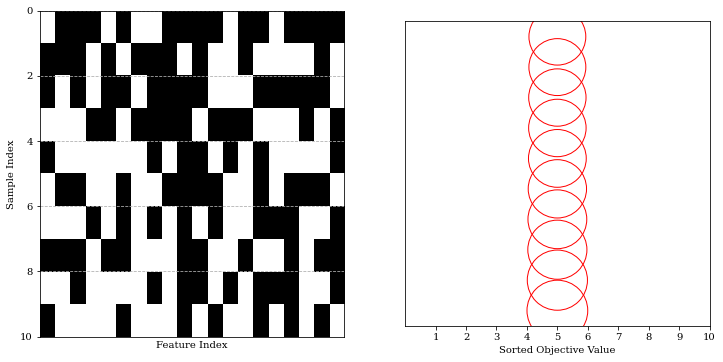

In [78]:
import numpy as np
import matplotlib.pyplot as plt

def sort_and_show_data(data, objective, top_k=10):
    # Sort data based on objective vector
    sorted_indices = np.argsort(objective)[::-1]
    sorted_data = data[sorted_indices][:top_k]
    sorted_objective = objective[sorted_indices][:top_k]
    # Plot sorted data
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot sorted data as image with flipped orientation
    ax1.imshow(sorted_data[::-1], cmap='binary', aspect='auto', extent=[0, 20, 0, len(sorted_data)])
    
    # Set labels and ticks for ax1
    ax1.set_xticks([])
    ax1.set_yticks(np.arange(0, 11, 2))
    ax1.set_yticklabels(np.arange(10, -1, -2))
    ax1.set_ylabel('Sample Index')
    ax1.set_xlabel('Feature Index')
    ax1.grid(axis='y', linestyle='--')

    print(sorted_objective)
    # Plot circles representing the objective vector with flipped orientation
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 10)
    for i, val in enumerate(sorted_objective):
        ax2.add_patch(plt.Circle((5, i + 0.5), val * 1, color='red', fill=False))

    # Set labels and ticks for ax2
    ax2.set_xticks(np.arange(1, 11))
    ax2.set_yticks([])
    ax2.set_xlabel('Sorted Objective Value')
    ax2.set_aspect('equal')

    plt.show()

# Example usage:
# Assuming you have data of shape (n, 20) and objective vector of shape (n, 1)
n = 100  # Number of samples
data = np.random.randint(0, 2, size=(n, 20))  # Example binary data
objective = np.random.rand(n)  # Example objective vector
sort_and_show_data(data, objective)
